In [3]:
# Initial Imports
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [5]:
#Read in the data and slice out the country we want to research
df = pd.read_csv(
    Path("WEOApr2021all.csv")
)

df = df[(df["Subject Descriptor"]=="Gross domestic product, current prices") & (df["Units"]=="U.S. dollars")]
df.drop(columns=["Subject Descriptor", "Units", "Scale", "Estimates Start After"], inplace=True)
df = df.T
df.columns = df.loc["Country"]
df = df.drop("Country", axis=0)
df.head()

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
WEO Country Code,512,914,612,614,311,213,911,314,193,122,...,111,298,927,846,299,582,487,474,754,698
ISO,AFG,ALB,DZA,AGO,ATG,ARG,ARM,ABW,AUS,AUT,...,USA,URY,UZB,VUT,VEN,VNM,WBG,YEM,ZMB,ZWE
WEO Subject Code,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,...,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD,NGDPD
Subject Notes,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...,Values are based upon GDP in national currency...
Country/Series-specific Notes,"See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...",...,"See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren...","See notes for: Gross domestic product, curren..."


In [6]:
# selcect other country data from masterr data set
china_df = df[['China']]

china_gdp = china_df.drop(labels=["WEO Country Code", "ISO", "WEO Subject Code", "Subject Notes", "Country/Series-specific Notes"], axis=0)

china_gdp.rename(columns = {'Country':'Year'}, inplace = True)

# make sure all data is in float type for ease 
china_gdp = china_gdp.replace(",","", regex=True)
china_gdp = china_gdp.astype("float")
china_gdp["lagged GDP"] = china_gdp[["China"]]
#d['gdp'] = df['gdp'].shift(-5)
china_gdp["lagged GDP"] = china_gdp['lagged GDP']
china_gdp.dropna(inplace=True)
china_gdp

Country,China,lagged GDP
1980,303.027,303.027
1981,288.734,288.734
1982,284.608,284.608
1983,305.426,305.426
1984,314.224,314.224
1985,310.151,310.151
1986,300.924,300.924
1987,327.719,327.719
1988,408.652,408.652
1989,458.167,458.167


In [7]:
# use Window_data function to set up the arrays for X and Y
def window_data(china_gdp, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(china_gdp) - window):
        features = china_gdp.iloc[i : (i + window), feature_col_number]
        target = china_gdp.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [8]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 20
#after adding a shifted column then set that as target column 
feature_column = 0
target_column = 1
X, y = window_data(china_gdp, window_size, feature_column, target_column)
print (f"X sample values:\n{X} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[  303.027   288.734   284.608   305.426   314.224   310.151   300.924
    327.719   408.652   458.167   396.58    413.217   492.155   617.429
    561.687   731.018   860.476   957.993  1024.17   1088.34 ]
 [  288.734   284.608   305.426   314.224   310.151   300.924   327.719
    408.652   458.167   396.58    413.217   492.155   617.429   561.687
    731.018   860.476   957.993  1024.17   1088.34   1205.52 ]
 [  284.608   305.426   314.224   310.151   300.924   327.719   408.652
    458.167   396.58    413.217   492.155   617.429   561.687   731.018
    860.476   957.993  1024.17   1088.34   1205.52   1333.67 ]
 [  305.426   314.224   310.151   300.924   327.719   408.652   458.167
    396.58    413.217   492.155   617.429   561.687   731.018   860.476
    957.993  1024.17   1088.34   1205.52   1333.67   1465.84 ]
 [  314.224   310.151   300.924   327.719   408.652   458.167   396.58
    413.217   492.155   617.429   561.687   731.018   860.476   957.993
   1024.17  

In [34]:
# Use 90% of the data for training and the remainder for testing
split = int(0.9 * len(X))
X_train = X[: split]
X_test = X[split - 20:]
y_train = y[: split]
y_test = y[split - 20:]

In [35]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)
X_test.shape

(23, 20)

In [36]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.00745859]
  [0.00126136]
  [0.        ]
  [0.00094025]
  [0.00231995]
  [0.00128307]
  [0.        ]
  [0.        ]
  [0.00119199]
  [0.00574669]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.00404546]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.00167078]
  [0.        ]
  [0.00484952]
  [0.00277774]
  [0.00160949]
  [0.        ]
  [0.00325239]
  [0.00870498]
  [0.00608109]
  [0.        ]
  [0.00153612]
  [0.00666025]
  [0.009384  ]
  [0.        ]
  [0.01195743]
  [0.00813623]
  [0.00568515]
  [0.00358382]
  [0.00322684]
  [0.00547747]]

 [[0.        ]
  [0.00636427]
  [0.00689901]
  [0.00192708]
  [0.        ]
  [0.00372601]
  [0.01307609]
  [0.01403071]
  [0.        ]
  [0.0015524 ]
  [0.00882462]
  [0.01723002]
  [0.00520849]
  [0.01228914]
  [0.0210992 ]
  [0.01426502]
  [0.00954321]
  [0.00705895]
  [0.00911934]
  [0.01146772]]

 [[0.00843004]
  [0.00905391]
  [0.00595021]
  [0.        ]
  [0.004673

In [37]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [38]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.4

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))


model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer


model.add(Dense(1))

In [39]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error", metrics= ["accuracy"])

In [40]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20, 5)             140       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 5)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 5)             220       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 5)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_5 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [41]:
# Train the model
model.fit(X_train, y_train, epochs=1000, shuffle=False, batch_size=1, verbose=1)

Epoch 1/1000
24/24 [==============================] - 2s 6ms/step - loss: 0.1202 - accuracy: 0.0417
Epoch 2/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0885 - accuracy: 0.0417: 0s - loss: 0.0442 - accuracy: 0.05
Epoch 3/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0685 - accuracy: 0.0417: 0s - loss: 0.0124 - accuracy: 0.
Epoch 4/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0349 - accuracy: 0.0417
Epoch 5/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0401 - accuracy: 0.0417
Epoch 6/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0382 - accuracy: 0.0417
Epoch 7/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0379 - accuracy: 0.0417
Epoch 8/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0258 - accuracy: 0.0417
Epoch 9/1000
24/24 [==============================] - 0s 6ms/step - loss: 0.0605 - accuracy: 0.0417: 0s - loss: 0.0223 - accuracy:

In [42]:
# Evaluate the model
model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 552ms/step - loss: 0.0045 - accuracy: 0.0435


[0.004471312277019024, 0.043478261679410934]

In [43]:
#get predictions from the X_test
ch_predicted = model.predict(X_test)
ch_predicted.shape

(23, 1)

In [44]:
# Recover the original prices instead of the scaled version
ch_predicted_prices = scaler.inverse_transform(ch_predicted)
ch_real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [45]:
# Create a DataFrame of Real and Predicted values
china_GDP = pd.DataFrame({
    "Real": ch_real_prices.ravel(),
    "Predicted": ch_predicted_prices.ravel()
    }, index = df.index[-len(ch_real_prices): ])
#china_GDP = china_gdp.dt.year.add(1).astype(str)
china_GDP.index = pd.to_datetime(china_GDP.index, format='%Y')
#china_GDP.index = china_GDP.index.shift(10, freq="Y")
china_GDP

,Real,Predicted
2004-01-01,1949.49,2856.041016
2005-01-01,2290.09,3156.167969
2006-01-01,2754.11,3540.837891
2007-01-01,3555.68,4053.634521
2008-01-01,4577.40,4715.876465
2009-01-01,5088.99,5479.773438
2010-01-01,6033.81,6330.622070
2011-01-01,7492.26,7378.400879
2012-01-01,8539.47,8459.828125
2013-01-01,9625.04,9394.857422


<AxesSubplot:>

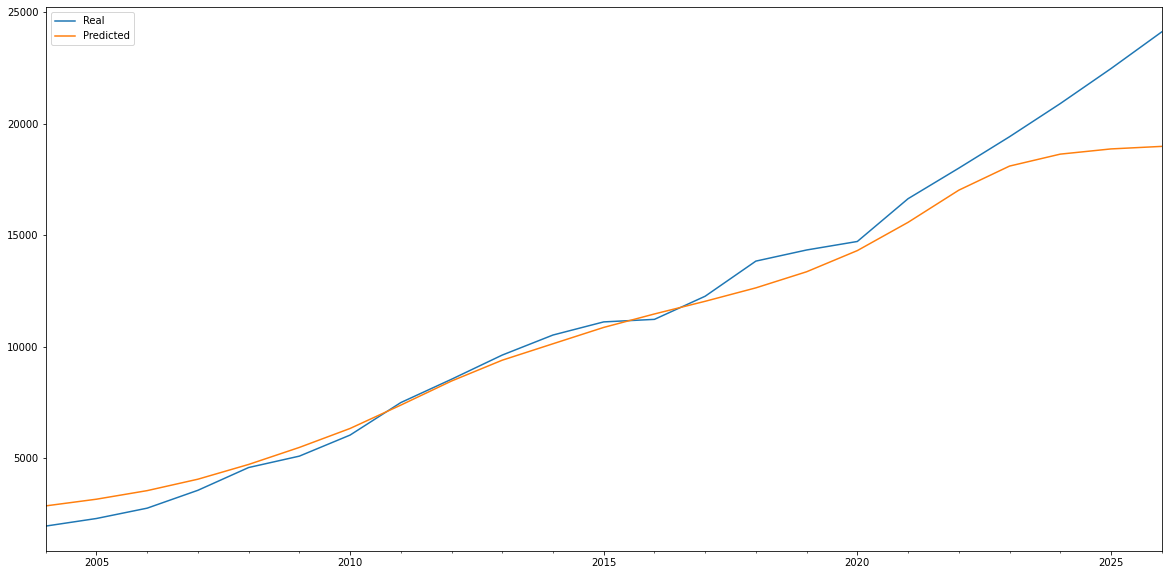

In [46]:
# Plot the real vs predicted prices as a line chart
china_GDP.plot(figsize=(20,10))

In [47]:
from sklearn.metrics import r2_score

In [48]:
y_true = china_GDP['Real']
y_pred = china_GDP['Predicted']

In [49]:
r2_score(y_true, y_pred)

0.9453337966483488